<a href="https://colab.research.google.com/github/RebatiGaire/TensorflowInPractice/blob/master/happy_or_sad_conv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import tensorflow as tf
import os
import zipfile
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
DESIRED_ACCURACY = 0.999

!wget --no-check-certificate \
    "https://storage.googleapis.com/laurencemoroney-blog.appspot.com/happy-or-sad.zip" \
    -O "/tmp/happy-or-sad.zip"

zip_ref = zipfile.ZipFile("/tmp/happy-or-sad.zip", 'r')
zip_ref.extractall("/tmp/h-or-s")
zip_ref.close()

--2020-04-05 17:58:26--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/happy-or-sad.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.28.128, 2607:f8b0:400e:c0a::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.28.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2670333 (2.5M) [application/zip]
Saving to: ‘/tmp/happy-or-sad.zip’

/tmp/happy-or-sad.z 100%[===================>]   2.55M  --.-KB/s    in 0.01s   

2020-04-05 17:58:26 (188 MB/s) - ‘/tmp/happy-or-sad.zip’ saved [2670333/2670333]



In [0]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs = {}):
        if (logs.get('accuracy') > DESIRED_ACCURACY):
            print('\nReached ' + str(DESIRED_ACCURACY * 100) + '% accuracy so cancelling training!")')
            self.model.stop_training = True

In [17]:
callbacks = myCallback()
    
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation = 'relu', input_shape = (150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation = 'relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 34, 34, 32)        9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 17, 17, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9248)             

In [0]:
model.compile(loss = 'binary_crossentropy', 
                  optimizer = RMSprop(lr = 0.001),
                  metrics = ['accuracy'],)

In [19]:
train_datagen = ImageDataGenerator(rescale = 1.0/255)
train_generator = train_datagen.flow_from_directory(
        '/tmp/h-or-s',
        target_size = (150, 150),
        batch_size = 128,
        class_mode = 'binary',)

Found 80 images belonging to 2 classes.


In [20]:
history = model.fit_generator(
        train_generator,
        steps_per_epoch = 8,
        epochs = 15,
        verbose = 1,
        callbacks = [callbacks])

Epoch 1/15
8/8 [==============================] - 10s 1s/step - loss: 0.9322 - accuracy: 0.5750
Epoch 2/15
8/8 [==============================] - 10s 1s/step - loss: 0.2694 - accuracy: 0.8594
Epoch 3/15
8/8 [==============================] - 10s 1s/step - loss: 0.1259 - accuracy: 0.9688
Epoch 4/15
8/8 [==============================] - 10s 1s/step - loss: 0.0511 - accuracy: 0.9797
Epoch 5/15
8/8 [==============================] - 10s 1s/step - loss: 0.0176 - accuracy: 0.9969
Epoch 6/15
8/8 [==============================] - ETA: 0s - loss: 0.0058 - accuracy: 1.0000{'loss': 0.00577812734991312, 'accuracy': 1.0}

Reached 99.9% accuracy so cancelling training!")
8/8 [==============================] - 10s 1s/step - loss: 0.0058 - accuracy: 1.0000


In [22]:
history.history['accuracy'][-1]

1.0

Upload and Predict New Images

In [25]:
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(150, 150))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(classes[0])
  if classes[0]>0.5:
    print(fn + " is a happy")
  else:
    print(fn + " is a sad")
 

Saving happy.jpeg to happy (1).jpeg
[1.]
happy.jpeg is a happy


Visualizing Intermediate Representations

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in true_divide


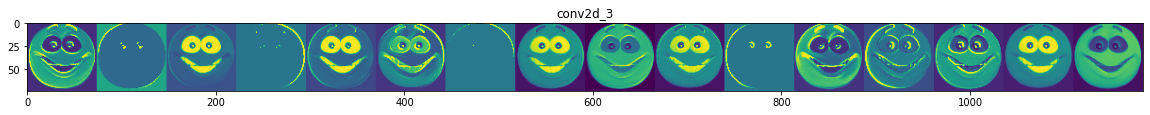

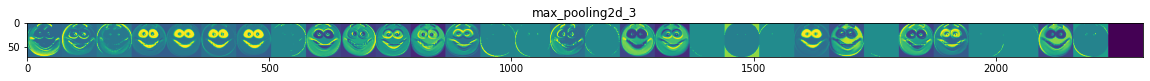

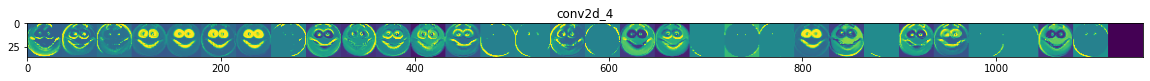

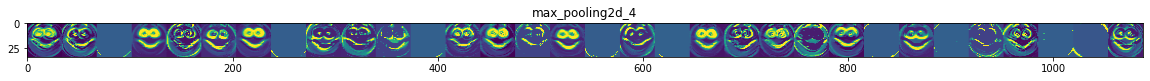

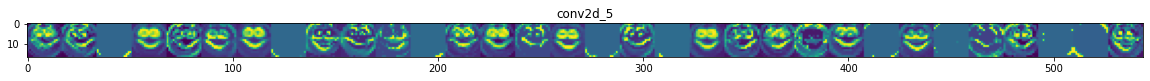

In [30]:
import numpy as np
import random
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# Let's define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model after
# the first.
successive_outputs = [layer.output for layer in model.layers[1:]]
#visualization_model = Model(img_input, successive_outputs)
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)
# Let's prepare a random input image from the training set.
happy_img_files = [os.path.join('/tmp/h-or-s/happy', f) for f in os.listdir('/tmp/h-or-s/happy')]
sad_img_files = [os.path.join('/tmp/h-or-s/sad', f) for f in os.listdir('/tmp/h-or-s/sad')]
img_path = random.choice(happy_img_files + sad_img_files)

img = load_img(img_path, target_size=(150, 150))  # this is a PIL image
x = img_to_array(img)  # Numpy array with shape (150, 150, 3)
x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 150, 150, 3)

# Rescale by 1/255
x /= 255

# Let's run our image through our network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers]

# Now let's display our representations
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  if len(feature_map.shape) == 4:
    # Just do this for the conv / maxpool layers, not the fully-connected layers
    n_features = feature_map.shape[-1]  # number of features in feature map
    # The feature map has shape (1, size, size, n_features)
    size = feature_map.shape[1]
    # We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))
    for i in range(n_features):
      # Postprocess the feature to make it visually palatable
      x = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std()
      x *= 64
      x += 128
      x = np.clip(x, 0, 255).astype('uint8')
      # We'll tile each filter into this big horizontal grid
      display_grid[:, i * size : (i + 1) * size] = x
    # Display the grid
    scale = 20. / n_features
    plt.figure(figsize=(scale * n_features, scale))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')